In [112]:
import penkit.write
%matplotlib inline
import matplotlib.pyplot as plt
from penkit.preview import show_layer
from penkit.write import write_plot
import numpy as np

In [113]:
def make_joy_texture(num_lines=10, resolution=50):
    # np.meshgrid is a handy way to generate a grid of points. It
    # returns a pair of matrices, which we will flatten into arrays.
    # For the x-coordinates, we put a nan value at the end so that when
    # we flatten them there is a separater between each horizontal line.
    x, y = np.meshgrid(
        np.hstack([np.linspace(0, 1, resolution), np.nan]),
        np.linspace(0, 1, num_lines),
    )
    
    # For coordinates where the x value is nan, set the y value to nan
    # as well. nan coordinates represent breaks in the path, indicating
    # here that the pen should be raised between each horizontal line.
    y[np.isnan(x)] = np.nan
    return x.flatten(), y.flatten()

In [114]:
joy_texture = make_joy_texture(6)

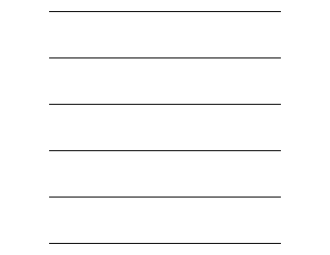

In [115]:
show_layer(joy_texture)

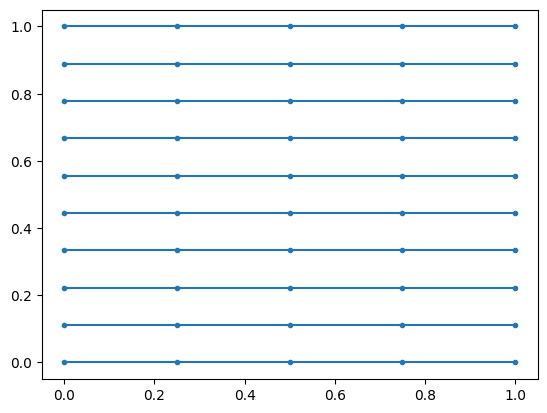

In [116]:
plt.plot(*make_joy_texture(10, 5), marker='.')

In [117]:
from scipy.ndimage import gaussian_filter

# This step isn't necessary, but it ensures that the same "random" plot
# will be generated every time the tutorial is run.
np.random.seed(int('banana', 36))

NOISE_BLUR = 40
noise_surface = gaussian_filter(np.random.normal(size=(500, 500)), NOISE_BLUR)

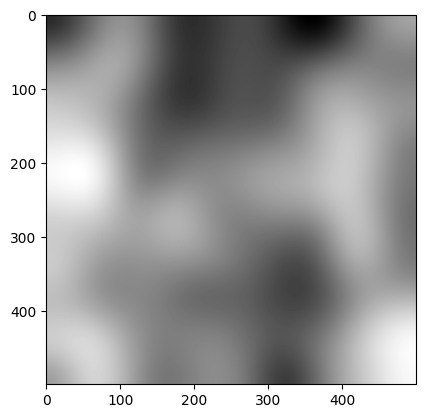

In [118]:
plt.imshow(noise_surface, cmap='gray');

In [119]:
SURFACE_SIZE = 500
grid = np.meshgrid(
    np.linspace(0, 1, SURFACE_SIZE),
    np.linspace(0, 1, SURFACE_SIZE)
)

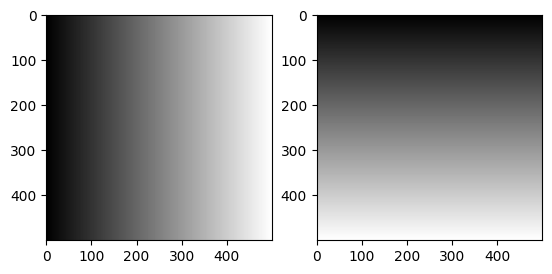

In [120]:
_, (p1, p2) = plt.subplots(1, 2)
p1.imshow(grid[0], cmap='gray')
p2.imshow(grid[1], cmap='gray');

In [150]:
hole_surface = np.sin(
    np.linalg.norm((np.array(grid) - 0.5) * np.pi, axis=0))

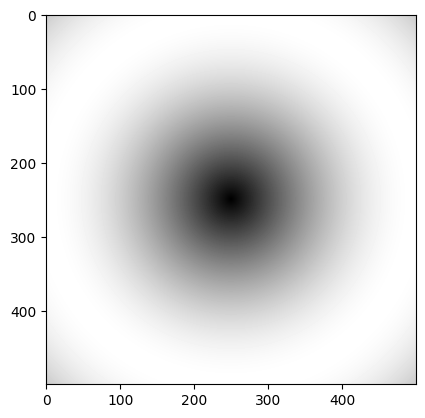

In [151]:
plt.imshow(hole_surface, cmap='gray');

In [152]:
NUM_BUBBLES_PER_SIDE = 10
bubble_surface = (
    np.sin((grid[0] - 0.5) * NUM_BUBBLES_PER_SIDE * np.pi) *
    np.sin((grid[1] - 0.5) * NUM_BUBBLES_PER_SIDE * np.pi))

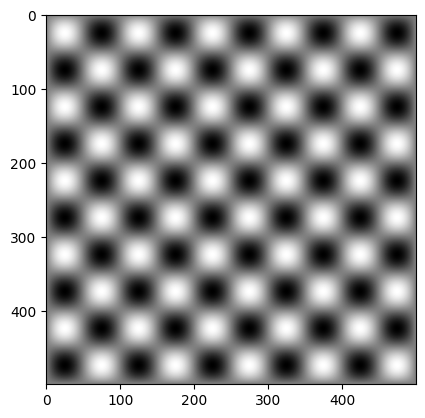

In [153]:
plt.imshow(bubble_surface, cmap='gray');

In [125]:
def texture_map(texture, surface):
    texture_x, texture_y = texture
    surface_w, surface_h = surface.shape
    
    # First, we convert the points along the texture into integers within
    # the bounds of the surface's index. The clipping here will also convert
    # the nan values to 0.
    index_x = np.clip(np.int32(surface_w * texture_x), 0, surface_w - 1)
    index_y = np.clip(np.int32(surface_h * texture_y), 0, surface_h - 1)
    
    # Grab z-values along the texture path. Note that this will include values
    # for every point, even if it is nan or had to be clipped to within the
    # bounds of the surface, so we have to fix that next.
    surface_z = surface[index_x, index_y]
    
    # Set z-values that are either out of bounds or nan in the texture to nan
    # in the output.
    # Numpy wants to warn about the fact that there are nan values in the
    # textures, so we silence warnings about this.
    with np.errstate(invalid='ignore'):
        surface_z[(texture_x < 0) | (texture_x >= 1) |
                  (texture_y < 0) | (texture_y >= 1)] = np.nan
    
    return surface_z

In [126]:
def texture_plot(texture, surface, angle=45, **kwargs):
    # Extract the Xs and Ys from the texture
    surface_x, surface_y = texture
    
    # Map the texture to get the Zs
    surface_z = texture_map(texture, surface.T)
    
    # The projection is as simple as linearly blending the Z and Y
    # dimensions. The multiples are calculated from the given
    # angle with standard trig.
    z_coef = np.sin(np.radians(angle))
    y_coef = np.cos(np.radians(angle))
    plot = (surface_x, -surface_y * y_coef + surface_z * z_coef)

    return show_layer(plot, **kwargs)

C:\Users\User\AppData\Local\Temp\ipykernel_9580\2479872720.py:8: RuntimeWarning: invalid value encountered in cast
  index_x = np.clip(np.int32(surface_w * texture_x), 0, surface_w - 1)
C:\Users\User\AppData\Local\Temp\ipykernel_9580\2479872720.py:9: RuntimeWarning: invalid value encountered in cast
  index_y = np.clip(np.int32(surface_h * texture_y), 0, surface_h - 1)


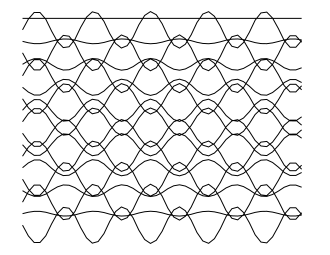

In [154]:
texture_plot(make_joy_texture(20), bubble_surface * 0.1, 40)

C:\Users\User\AppData\Local\Temp\ipykernel_9580\2479872720.py:8: RuntimeWarning: invalid value encountered in cast
  index_x = np.clip(np.int32(surface_w * texture_x), 0, surface_w - 1)
C:\Users\User\AppData\Local\Temp\ipykernel_9580\2479872720.py:9: RuntimeWarning: invalid value encountered in cast
  index_y = np.clip(np.int32(surface_h * texture_y), 0, surface_h - 1)


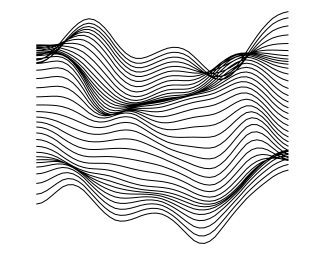

In [155]:
texture_plot(make_joy_texture(40), noise_surface * 12, 40)

In [129]:
def make_visible_mask(surface, angle):
    s = surface.shape[0]
    
    # Just as in projection, we calculate the Y and Z
    # coefficients with sin/cos.
    y_coef = np.cos(np.radians(angle))
    z_coef = np.sin(np.radians(angle))
    
    # Rotate the surface so that the visibilty mask represents
    # the visibility at the desired angle.
    projected_surface = (
        z_coef * surface -
        y_coef * np.expand_dims(np.linspace(0., 1., s), axis=1)
    )
    
    # Calculate the cumulative maximum along each cross-section of
    # the projected surface. We flip on the input and output because
    # we want to accumulate from the bottom of the surface up, rather
    # than the top-down. This is because we interpret the bottom of
    # the surface as closer to the observer.
    projected_surface_max = np.flipud(np.maximum.accumulate(np.flipud(projected_surface)))
    
    # Compare each point on the surface to the cumulative maximum
    # along its cross-section.
    return projected_surface == projected_surface_max

In [130]:
def remove_hidden_parts(surface, angle):
    surface = np.copy(surface)
    surface[~make_visible_mask(surface, angle)] = np.nan
    return surface

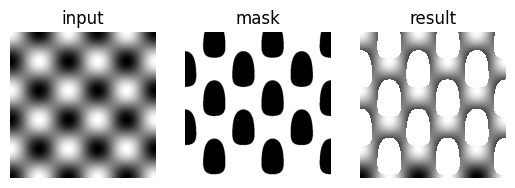

In [131]:
_, (i, m, r) = plt.subplots(1, 3)
# Plot input surface
i.imshow(bubble_surface, cmap='gray')
i.set_title('input')
i.axis('off')
# Plot mask
m.imshow(make_visible_mask(bubble_surface, 10), cmap='gray')
m.set_title('mask')
m.axis('off')
# Plot result
r.imshow(remove_hidden_parts(bubble_surface, 10), cmap='gray')
r.set_title('result')
r.axis('off');

C:\Users\User\AppData\Local\Temp\ipykernel_9580\2479872720.py:8: RuntimeWarning: invalid value encountered in cast
  index_x = np.clip(np.int32(surface_w * texture_x), 0, surface_w - 1)
C:\Users\User\AppData\Local\Temp\ipykernel_9580\2479872720.py:9: RuntimeWarning: invalid value encountered in cast
  index_y = np.clip(np.int32(surface_h * texture_y), 0, surface_h - 1)


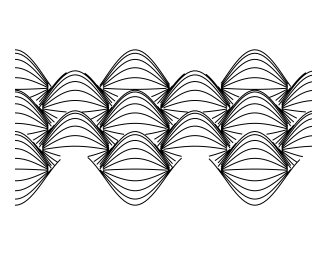

In [132]:
angle=70
texture_plot(make_joy_texture(50, 100), remove_hidden_parts(bubble_surface * 0.1, angle), angle)

C:\Users\User\AppData\Local\Temp\ipykernel_9580\2479872720.py:8: RuntimeWarning: invalid value encountered in cast
  index_x = np.clip(np.int32(surface_w * texture_x), 0, surface_w - 1)
C:\Users\User\AppData\Local\Temp\ipykernel_9580\2479872720.py:9: RuntimeWarning: invalid value encountered in cast
  index_y = np.clip(np.int32(surface_h * texture_y), 0, surface_h - 1)


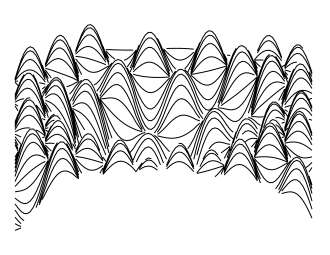

In [157]:
angle=65
texture_plot(make_joy_texture(80, 100), remove_hidden_parts(
    hole_surface * 1.2 + noise_surface + bubble_surface * 0.1, angle), angle)

In [134]:
def make_grid_texture(num_h_lines=10, num_v_lines=10, resolution=50):
    x_h, y_h = make_joy_texture(num_h_lines, resolution)
    y_v, x_v = make_joy_texture(num_v_lines, resolution)
    return np.concatenate([x_h, x_v]), np.concatenate([y_h, y_v] )

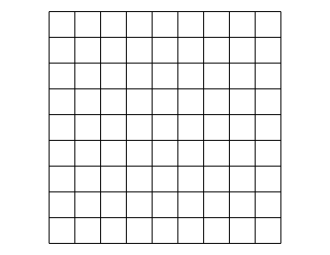

In [135]:
show_layer(make_grid_texture())

In [136]:
from penkit.textures.util import rotate_texture, fit_texture
grid_texture = fit_texture(rotate_texture(make_grid_texture(40, 40, 200), 40))

C:\Users\User\AppData\Local\Temp\ipykernel_9580\2479872720.py:8: RuntimeWarning: invalid value encountered in cast
  index_x = np.clip(np.int32(surface_w * texture_x), 0, surface_w - 1)
C:\Users\User\AppData\Local\Temp\ipykernel_9580\2479872720.py:9: RuntimeWarning: invalid value encountered in cast
  index_y = np.clip(np.int32(surface_h * texture_y), 0, surface_h - 1)


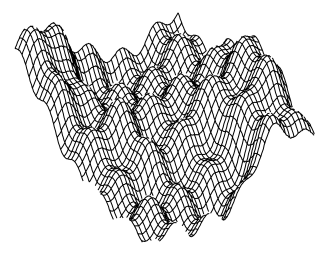

In [159]:
angle = 30
texture_plot(grid_texture, remove_hidden_parts(
    0.1 * hole_surface + 16 * noise_surface + 0.1 * bubble_surface, angle), angle)

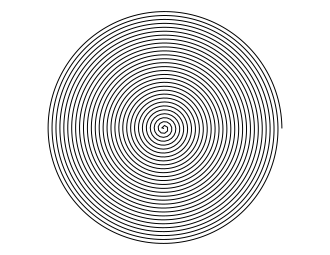

In [138]:
from penkit.textures import make_hex_texture, make_spiral_texture
spiral_texture = make_spiral_texture(
    spirals=30,     # how many full rotations to do
    ccw=False,      # whether to go counter-clockwise
    resolution=3000 # resolution (how many lines to use)
)
show_layer(spiral_texture)

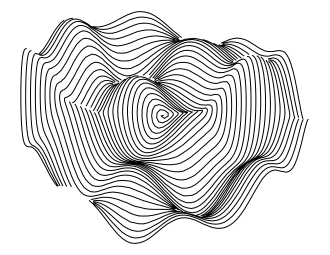

In [139]:
angle = 40
texture_plot(spiral_texture, remove_hidden_parts(
    0.1 * bubble_surface + 6 * noise_surface, angle), angle)

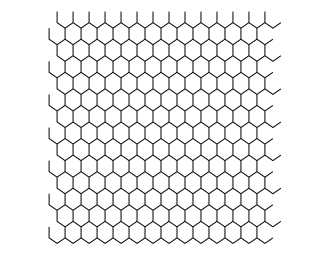

In [140]:
from penkit.textures import make_hex_texture
show_layer(make_hex_texture(14, 10))

C:\Users\User\AppData\Local\Temp\ipykernel_9580\2479872720.py:8: RuntimeWarning: invalid value encountered in cast
  index_x = np.clip(np.int32(surface_w * texture_x), 0, surface_w - 1)
C:\Users\User\AppData\Local\Temp\ipykernel_9580\2479872720.py:9: RuntimeWarning: invalid value encountered in cast
  index_y = np.clip(np.int32(surface_h * texture_y), 0, surface_h - 1)


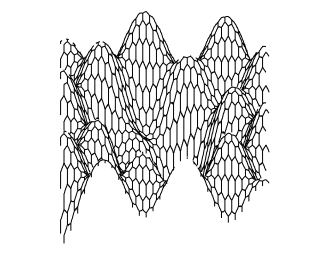

In [141]:
angle = 45
texture_plot(make_hex_texture(30, 10), remove_hidden_parts(
    hole_surface + 0.2 * bubble_surface, angle), angle)

In [142]:
angle = 45
x = texture_plot(make_hex_texture(30, 10), remove_hidden_parts(
    hole_surface + 0.2 * bubble_surface, angle), angle)
write_plot(x, filename='test.svg')

C:\Users\User\AppData\Local\Temp\ipykernel_9580\2479872720.py:8: RuntimeWarning: invalid value encountered in cast
  index_x = np.clip(np.int32(surface_w * texture_x), 0, surface_w - 1)
C:\Users\User\AppData\Local\Temp\ipykernel_9580\2479872720.py:9: RuntimeWarning: invalid value encountered in cast
  index_y = np.clip(np.int32(surface_h * texture_y), 0, surface_h - 1)


TypeError: 'SVG' object is not iterable

In [ ]:
def texture_plot_with_return(texture, surface, angle=45, **kwargs):
    # Extract the Xs and Ys from the texture
    surface_x, surface_y = texture
    
    # Map the texture to get the Zs
    surface_z = texture_map(texture, surface.T)
    
    # The projection is as simple as linearly blending the Z and Y
    # dimensions. The multiples are calculated from the given
    # angle with standard trig.
    z_coef = np.sin(np.radians(angle))
    y_coef = np.cos(np.radians(angle))
    plot = (surface_x, -surface_y * y_coef + surface_z * z_coef)

    return plot

In [147]:
import datetime
angle = 45
x = texture_plot_with_return(make_hex_texture(30, 10), remove_hidden_parts(
    hole_surface + 0.2 * bubble_surface, angle), angle)
write_plot([x], filename=f'rajz_{datetime.datetime.now().strftime("%m-%d-%Y-%H-%M-%S")}.svg')
import penkit
#print(type(x))
#print(x)
#penkit.write.plot_to_svg([x],400,400)

C:\Users\User\AppData\Local\Temp\ipykernel_9580\2479872720.py:8: RuntimeWarning: invalid value encountered in cast
  index_x = np.clip(np.int32(surface_w * texture_x), 0, surface_w - 1)
C:\Users\User\AppData\Local\Temp\ipykernel_9580\2479872720.py:9: RuntimeWarning: invalid value encountered in cast
  index_y = np.clip(np.int32(surface_h * texture_y), 0, surface_h - 1)


'04-26-2024-12-14-17'